<a href="https://colab.research.google.com/github/Aditya-Patel/Stat598-FinalProject/blob/main/MPLA_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
# Dataset
import yfinance as yf

# Visualization
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
mpl.rcParams['figure.dpi'] = 125
mpl.rcParams['figure.figsize'] = (10, 5)

# Date Manipulation
from datetime import datetime
from datetime import timedelta

# PyTorch Libraries
import tensorflow as tf
from tensorflow import keras

# statstical testing, plotting and decompositions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Set device usage to GPU if available
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
device = tf.device('/device:gpu:1')

In [93]:
# Neural Network Constants
TRAINING_EPOCHS = 500
BATCH_SIZE = 32
NEURON_CT = 256
POOL_SZ = 4
STRIDES = 1
LEARN_RATE = 0.1

In [94]:
start_date = '2020-06-01'
end_date = '2023-12-01'
etf_ticker = 'MLPA'
moving_average_list = []
etf_tickers_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/mlpa_full-holdings.csv"
crude_oil_stock_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/crude%20oil%20spot%20price.csv"

<h1>Create joint dataset between spot price and ETF Data</h1>

In [95]:
df_holdings = pd.read_csv(etf_tickers_url)
df_holdings = df_holdings[(df_holdings['Name'] != 'OTHER PAYABLE & RECEIVABLES') & (df_holdings['Name'] != 'CASH')]
df_holdings[f'Market Value ($)'] = df_holdings[f'Market Value ($)'].str.replace(',', '').astype(float)
total_market_value = df_holdings[f'Market Value ($)'].sum()
df_holdings['Percentage Holdings By Value'] = (df_holdings[f'Market Value ($)'] / total_market_value)

df_crude_price = pd.read_csv(crude_oil_stock_url,usecols=[0, 1])
df_crude_price['Date'] = pd.to_datetime(df_crude_price['Date'], format='%b %d, %Y')
df_crude_price.set_index('Date', inplace=True)
df_crude_price.rename(columns={'WTI Barrell Spot Price':'Spot Price'}, inplace=True)
df_crude_price['Spot Price'] = df_crude_price['Spot Price'].fillna(method='ffill')

all_stocks_data = yf.download(etf_ticker, start=start_date, end=end_date)

# Join spot price and etf data
all_stocks_data['Ticker'] = etf_ticker
all_stocks_data.columns = [f'{etf_ticker}_{col}' if col not in ['Ticker', 'Date'] else col for col in all_stocks_data.columns]
all_stocks_data = all_stocks_data.join(df_crude_price, how='left')

[*********************100%%**********************]  1 of 1 completed


<h1>Load all tickers within the ETF</h1>

In [96]:
# load all tickers part of that etf
for ticker in df_holdings['Ticker']:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    percentage_holding = df_holdings.loc[df_holdings['Ticker'] == ticker, 'Percentage Holdings By Value'].iloc[0]
    all_stocks_data[f'{ticker}_Percent_Holding'] = percentage_holding
    stock_data.columns = [f'{ticker}_{col}' if col != 'Ticker' else col for col in stock_data.columns]
    all_stocks_data = all_stocks_data.join(stock_data, how='outer')

all_stocks_data.fillna(0, inplace=True)
sum_values = pd.Series(0, index=all_stocks_data.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [97]:
# Get all closing values

all_stocks_data[f'{etf_ticker}_Next_Close'] = all_stocks_data[f'{etf_ticker}_Close'].shift(-1)
all_stocks_data = all_stocks_data.drop(all_stocks_data.index[-1])
close_values = all_stocks_data[[col for col in all_stocks_data.columns if '_Close' in col or col == 'Spot Price' or col == f'{etf_ticker}_Next_Close']]


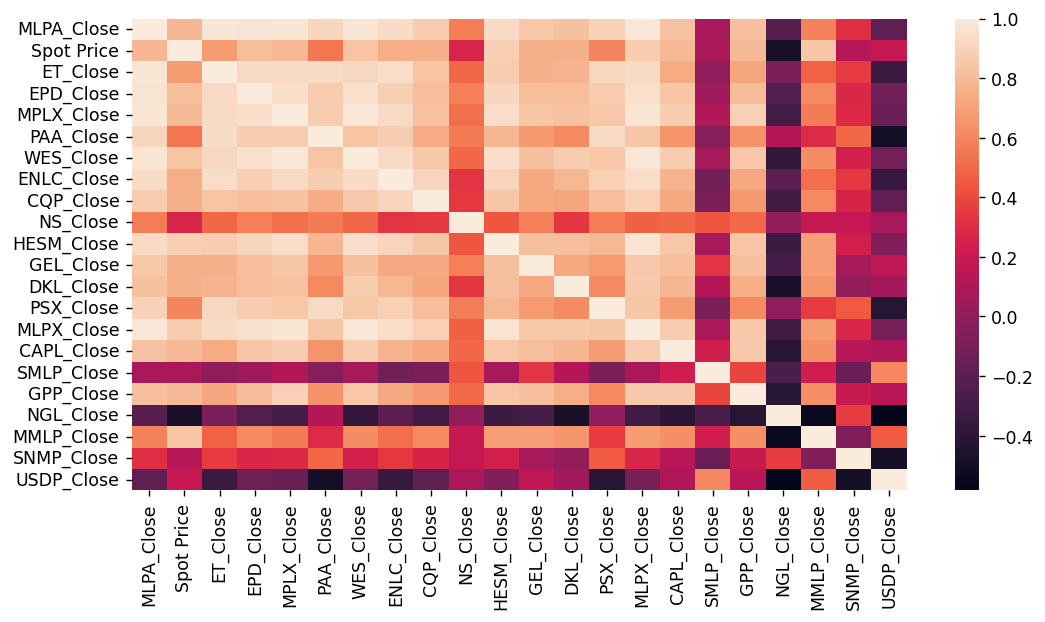

In [98]:
# Check correlation
df = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])
sns.heatmap(df.corr(), annot=False)
plt.show()

Based on the plot of the correlation matrix, we see that most of the stocks are correlated positively with each other with the exception of SMLP, NGL and USDP, which have negative correlation. We expect to see this as a good ETF consists of a variety of tickers to protect against large market swings either way.

<h1>Model Development<h1>
<h2> A Dense Neural Network is developed in TensorFlow to perform future analysis based on the previous closing price trend. <h2>

In [99]:
# Generate X and y input datasets - Since we are predicting the next day value, we use the 'Next_Close' as the target value
y = close_values[f'{etf_ticker}_Next_Close']
X = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

In [100]:
# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)

# Convert to tensors and prefetch
train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_df = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_df = train_df.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [101]:
# CNN - 3 Convolution Layers, 3 Dense Layers
model_1 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/4, kernel_size=(5,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/2, kernel_size=(5,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(5,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(1),
    keras.layers.Dense(1)
])

model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 20, 64)            256       
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 17, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_46 (Conv1D)          (None, 15, 128)           24704     
                                                                 
 max_pooling1d_42 (MaxPooli  (None, 12, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_47 (Conv1D)          (None, 4, 256)            295168    
                                                                 
 max_pooling1d_43 (MaxPooli  (None, 1, 256)          

In [121]:
# CNN 1- 2 Convolution Layers, 4 Dense Layers
model_2 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/4, kernel_size=(9,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(8,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(NEURON_CT/4, activation='relu'),
    keras.layers.Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')
model_2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 14, 64)            640       
                                                                 
 max_pooling1d_55 (MaxPooli  (None, 11, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_61 (Conv1D)          (None, 4, 256)            131328    
                                                                 
 max_pooling1d_56 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 dense_84 (Dense)            (None, 1, 256)            65792     
                                                                 
 dense_85 (Dense)            (None, 1, 128)          

In [103]:
# CNN 1- 4 Convolution Layers, 2 Dense Layers
model_3 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/8, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/2, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(4,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(1)
])

model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 20, 32)            128       
                                                                 
 max_pooling1d_46 (MaxPooli  (None, 17, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_51 (Conv1D)          (None, 15, 64)            6208      
                                                                 
 max_pooling1d_47 (MaxPooli  (None, 12, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_52 (Conv1D)          (None, 10, 128)           24704     
                                                                 
 max_pooling1d_48 (MaxPooli  (None, 7, 128)          

In [118]:
# CNN - 1 Convolution Layers, 3 Dense Layers
model_4 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT, kernel_size=(19,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(1)
])

model_4.compile(optimizer='adam', loss='mean_squared_error')
model_4.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 4, 256)            5120      
                                                                 
 max_pooling1d_50 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 dense_73 (Dense)            (None, 1, 256)            65792     
                                                                 
 dense_74 (Dense)            (None, 1, 128)            32896     
                                                                 
 dense_75 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 103937 (406.00 KB)
Trainable params: 103937 (406.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [105]:
# lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LEARN_RATE, patience=5)    

In [106]:
# Fit model to training data with 20% validation split
model_1.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.3)

model_2.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.3)

model_3.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.3)

model_4.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.3)

Epoch 1/500
12/12 [==============================] - 1s 15ms/step - loss: 205.6336 - val_loss: 24.9800
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 17.6048 - val_loss: 9.4803
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 9.9149 - val_loss: 7.1400
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 6.6045 - val_loss: 4.2035
Epoch 5/500
12/12 [==============================] - 0s 6ms/step - loss: 5.4170 - val_loss: 3.2355
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 4.6472 - val_loss: 2.5166
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 3.7567 - val_loss: 2.2657
Epoch 8/500
12/12 [==============================] - 0s 6ms/step - loss: 3.1791 - val_loss: 2.3100
Epoch 9/500
12/12 [==============================] - 0s 6ms/step - loss: 2.9865 - val_loss: 1.5462
Epoch 10/500
12/12 [==============================] - 0s 6ms/step - loss: 2.6847 - val_loss: 1.6701
Epoc

In [107]:
# Predict next close with all models
y1_pred = [val[0][0] for val in model_1.predict(test_df)]
mse1 = mean_squared_error(y_true=y_test, y_pred=y1_pred)


y2_pred = [val[0][0] for val in model_2.predict(test_df)]
mse2 = mean_squared_error(y_true=y_test, y_pred=y2_pred)


y3_pred = [val[0][0] for val in model_3.predict(test_df)]
mse3 = mean_squared_error(y_true=y_test, y_pred=y3_pred)

y4_pred = [val[0][0] for val in model_1.predict(test_df)]
mse4 = mean_squared_error(y_true=y_test, y_pred=y4_pred)

12/12 [==============================] - 0s 2ms/step


In [108]:
y1_NDP = model_1.predict(X)[-1][0][0]
y2_NDP = model_2.predict(X)[-1][0][0]
y3_NDP = model_3.predict(X)[-1][0][0]
y4_NDP = model_4.predict(X)[-1][0][0]


28/28 [==============================] - 0s 552us/step


In [109]:
results_df = pd.DataFrame(y_test)
results_df.columns = ['y_actual']
results_df['y1_pred'] = y1_pred
results_df['y2_pred'] = y2_pred
results_df['y3_pred'] = y3_pred
results_df['y4_pred'] = y4_pred
results_df.sort_index(inplace=True)

In [110]:
print(f'Hyperparameters: [Training Epochs: {TRAINING_EPOCHS} || Batch Size: {BATCH_SIZE} || Neurons: {NEURON_CT}]')
print(f'Price forecast: model_1: MSE: {mse1:.4f}')
print(f'Price forecast: model_2: MSE: {mse2:.4f}')
print(f'Price forecast: model_3: MSE: {mse3:.4f}')
print(f'Price forecast: model_4: MSE: {mse4:.4f}')

Hyperparameters: [Training Epochs: 500 || Batch Size: 32 || Neurons: 256]
Price forecast: model_1: MSE: 1.1037
Price forecast: model_2: MSE: 0.4993
Price forecast: model_3: MSE: 1.1528
Price forecast: model_4: MSE: 1.1037


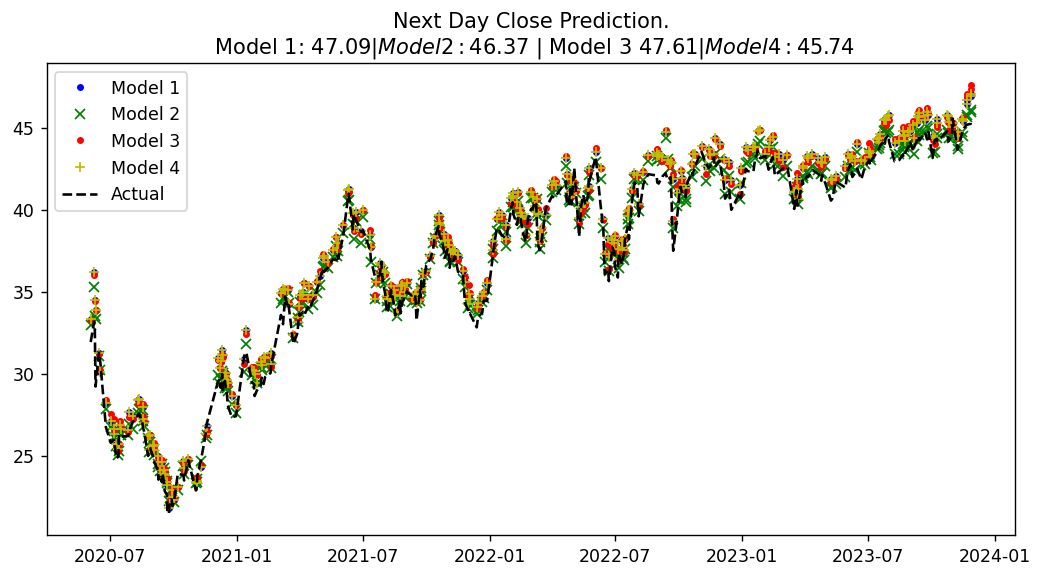

In [117]:
x = [x for x in range(len(y_test))]
plt.plot(results_df.y1_pred, '.b', label='Model 1')
plt.plot(results_df.y2_pred, 'xg', label='Model 2')
plt.plot(results_df.y3_pred, '.r', label='Model 3')
plt.plot(results_df.y4_pred, '+y', label='Model 4')
plt.plot(results_df.y_actual, '--k', label='Actual')
plt.title(f'Next Day Close Prediction.\n Model 1: ${y1_NDP:.2f} | Model 2: ${y2_NDP:.2f} | Model 3 ${y3_NDP:.2f} | Model 4: ${y4_NDP:.2f}')
plt.legend()
plt.show()

In [112]:
y1_sq_diff = (results_df.y_actual - results_df.y1_pred) ** 2
y1_diff = (results_df.y_actual - results_df.y1_pred)
y2_sq_diff = (results_df.y_actual - results_df.y2_pred) ** 2
y2_diff = (results_df.y_actual - results_df.y2_pred)
y3_sq_diff = (results_df.y_actual - results_df.y3_pred) ** 2
y3_diff = (results_df.y_actual - results_df.y3_pred)
y4_sq_diff = (results_df.y_actual - results_df.y4_pred) ** 2
y4_diff = (results_df.y_actual - results_df.y4_pred)

# Report maximum error for prediction date - index + 1
y1_idxmax = y1_sq_diff.idxmax().date() + timedelta(days=1)
y1_errmax = y1_diff[y1_sq_diff.idxmax()]
y2_idxmax = y2_sq_diff.idxmax().date() + timedelta(days=1)
y2_errmax = y2_diff[y2_sq_diff.idxmax()]
y3_idxmax = y3_sq_diff.idxmax().date() + timedelta(days=1)
y3_errmax = y3_diff[y3_sq_diff.idxmax()]
y4_idxmax = y4_sq_diff.idxmax().date() + timedelta(days=1)
y4_errmax = y4_diff[y4_sq_diff.idxmax()]

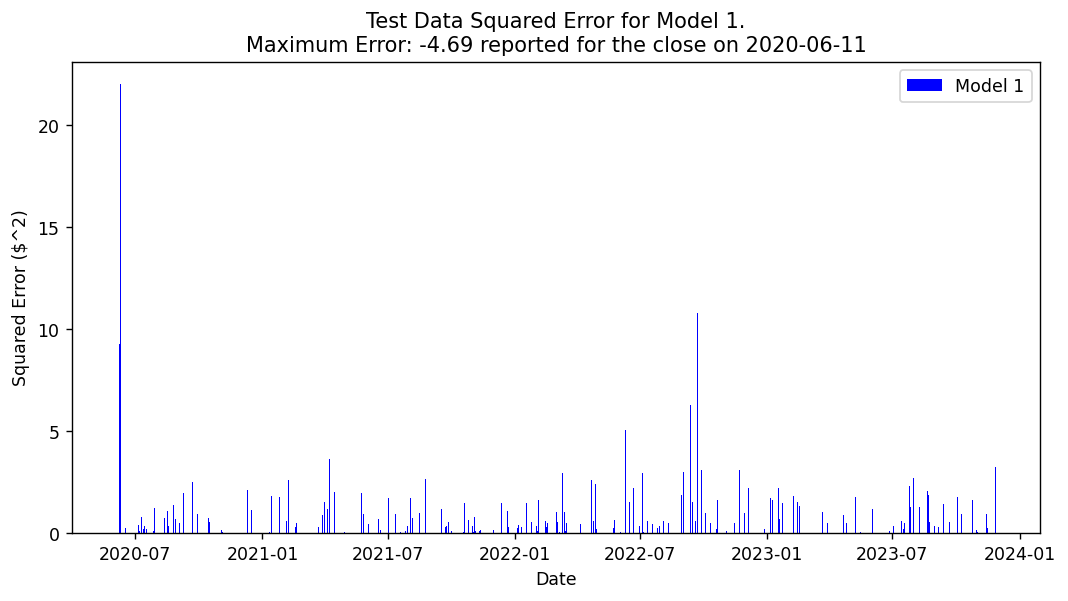

In [113]:
plot_label = 'Model 1'
plt.bar(results_df.index, y1_sq_diff, color='blue', label=plot_label)
plt.title(f'Test Data Squared Error for {plot_label}.\nMaximum Error: {y1_errmax:.2f} reported for the close on {y1_idxmax}')
plt.ylabel('Squared Error ($^2)')
plt.xlabel('Date')
plt.legend()
plt.show()

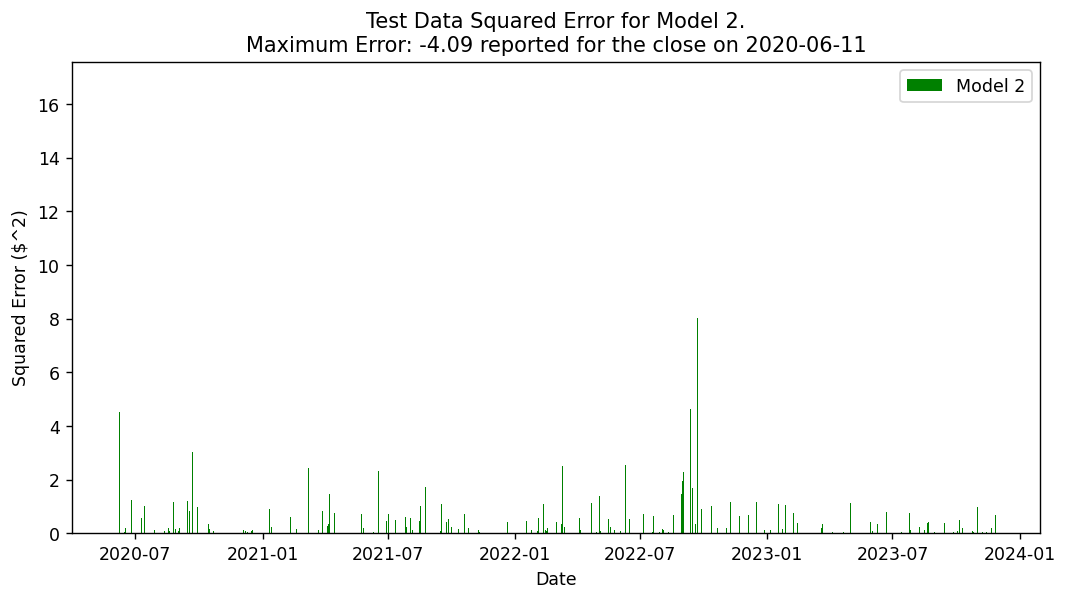

In [114]:
plot_label = 'Model 2'
plt.bar(results_df.index, y2_sq_diff, color='green', label=plot_label)
plt.title(f'Test Data Squared Error for {plot_label}.\nMaximum Error: {y2_errmax:.2f} reported for the close on {y2_idxmax}')
plt.ylabel('Squared Error ($^2)')
plt.xlabel('Date')
plt.legend()
plt.show()

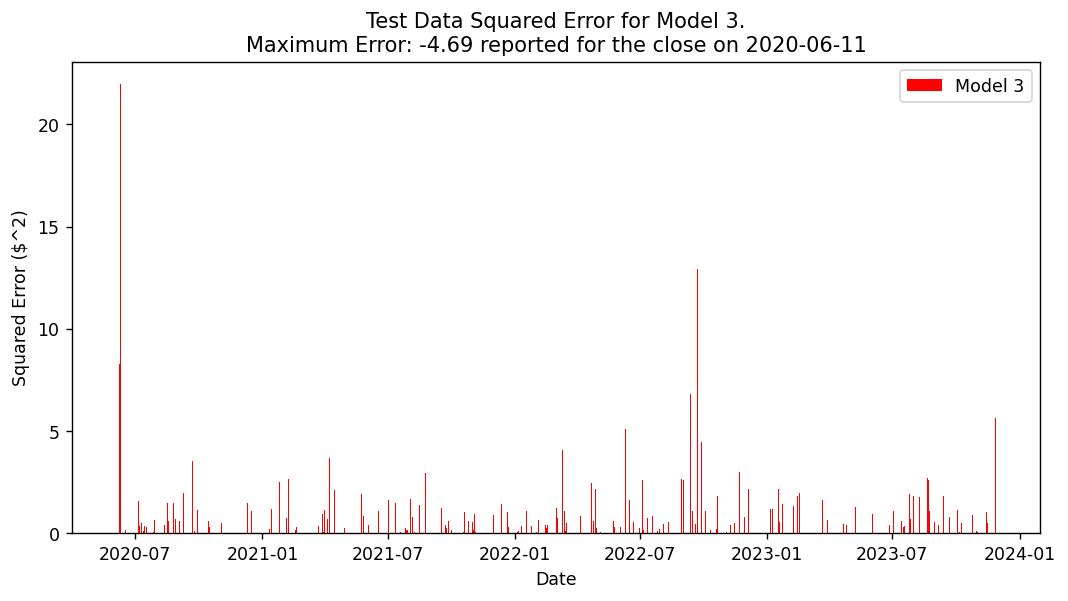

In [115]:
plot_label = 'Model 3'
plt.bar(results_df.index, y3_sq_diff, color='red', label=plot_label)
plt.title(f'Test Data Squared Error for {plot_label}.\nMaximum Error: {y3_errmax:.2f} reported for the close on {y3_idxmax}')
plt.ylabel('Squared Error ($^2)')
plt.xlabel('Date')
plt.legend()
plt.show()

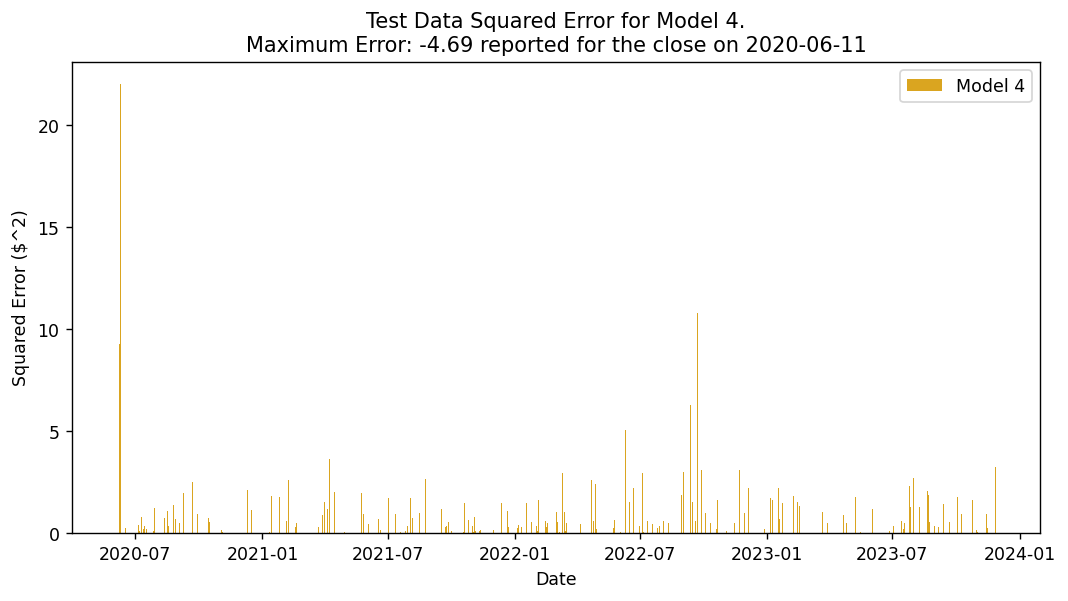

In [116]:
plot_label = 'Model 4'
plt.bar(results_df.index, y4_sq_diff, color='goldenrod', label=plot_label)
plt.title(f'Test Data Squared Error for {plot_label}.\nMaximum Error: {y4_errmax:.2f} reported for the close on {y4_idxmax}')
plt.ylabel('Squared Error ($^2)')
plt.xlabel('Date')
plt.legend()
plt.show()